# <center style="background-color:#606F66;color: white; vertical-align: middle; padding:20px 5px;">Aerial Semantic Segmentation Drone </center>

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Importing Libraries</center>

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
from PIL import Image

import imgaug as ia
from imgaug import augmenters

from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from Folder2BatchDataset import TO_batch


ModuleNotFoundError: No module named 'Folder2BatchDataset'

# <center style="background-color:#54A57C;color: white; vertical-align: middle; padding:10px 5px;">Preprocessing</center>

In [10]:
#IMG properties
IMG_HEIGHT   = 800
IMG_WIDTH    = 1200
IMG_CHANNELS = 3
Num_Classes  = 23

reshape_dims = (IMG_HEIGHT,IMG_WIDTH)
combined=[Num_Classes,reshape_dims]# to pass as argument for map function
batch_size = 2

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Image Path glob</center>

In [11]:
reshape_dims

(800, 1200)

In [14]:
decct={
    "IMG_HEIGHT"   : 800,
    "IMG_WIDTH"    : 1200,
    "IMG_CHANNELS" : 3,
    "Num_Classes"  : 23,
    "combined":[23,(800, 1200)]
    
    
    }

rot_90 = augmenters.Rot90(1,keep_size=False) #rot_90 = augmenters.Rot90(times) #time=1 =>90deg, time=2 =>180deg, time=3 =>270deg
rot_180 = augmenters.Rot90(2,keep_size=False) 
rot_270 = augmenters.Rot90(3,keep_size=False)
flip_hor = augmenters.Fliplr(1) 
fli_vert = augmenters.Flipud(1)

pipeline = [rot_90, rot_180, rot_270, flip_hor, fli_vert]


def kkwag(ZOB):

    return ZOB["IMG_HEIGHT"]*ZOB["IMG_WIDTH"]



In [15]:
kkwag(decct)

960000

In [3]:
#Mask related paths
RGB_Mask_PNG_LIST = tf.io.gfile.glob("../Data/RGB_color_image_masks/*.png")
RGB_Mask_PNG_LIST.sort()

RGB_to_mask_path = '../Data/1Mask'
Mask_aug_path    = '../Data/2Mask_Augmented'

#orginal Re;lated paths
ORIGINAL_JPG_LIST = tf.io.gfile.glob('../Data/1original_images/*.jpg')
ORIGINAL_JPG_LIST.sort()
Orginal_aug_path = '../Data/2Orginal_Augmented'

read_csv = pd.read_csv('../Data/class_dict_seg.csv',index_col=False,skipinitialspace=True)



## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">RGB to Mask</center>

In [4]:
#RGB_to_Mask(read_csv,RGB_Mask_PNG_LIST,RGB_to_mask_path) #only one time run
Mask_PNG_LIST = tf.io.gfile.glob("../Data/1Mask/*.png")
Mask_PNG_LIST.sort()

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Augmentaion</center>

In [2]:
rot_90 = augmenters.Rot90(1,keep_size=False) #rot_90 = augmenters.Rot90(times) #time=1 =>90deg, time=2 =>180deg, time=3 =>270deg
rot_180 = augmenters.Rot90(2,keep_size=False) 
rot_270 = augmenters.Rot90(3,keep_size=False)
flip_hor = augmenters.Fliplr(1) 
fli_vert = augmenters.Flipud(1)

pipeline = [rot_90, rot_180, rot_270, flip_hor, fli_vert]


#image_augmentation(ORIGINAL_JPG_LIST,Orginal_aug_path,pipeline)#orginal augmentaion
#image_augmentation(Mask_PNG_LIST,Mask_aug_path,pipeline)#mask augmentaion



NameError: name 'ORIGINAL_JPG_LIST' is not defined

In [6]:


ORIGINAL_JPG_LIST_with_aug = ORIGINAL_JPG_LIST+tf.io.gfile.glob('../Data/2Orginal_Augmented/*.jpg')
Mask_PNG_LIST_with_aug      = Mask_PNG_LIST+tf.io.gfile.glob('../Data/2Mask_Augmented/*.png')


index= [os.path.splitext(filename)[0] for filename in os.listdir('../Data/1original_images/')]
index_with_aug=index+[os.path.splitext(filename)[0] for filename in os.listdir('../Data/2Orginal_Augmented/')]

ORIGINAL_JPG_LIST_with_aug.sort()
Mask_PNG_LIST_with_aug.sort()
index_with_aug.sort()

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Creating Dataframe from paths</center>

In [7]:
df=pd.DataFrame((index_with_aug,ORIGINAL_JPG_LIST_with_aug,Mask_PNG_LIST_with_aug)).T
df.rename(columns={
    0: 'index',
    1: 'Orginal',
    2: 'Segmented'},
          inplace=True)
df.set_index('index', inplace= True)
df.to_csv('DataFrame.csv')

#df = shuffle(df)


In [8]:
X_train,X_val = train_test_split(df, test_size=0.2, random_state=42)
X_val,X_test = train_test_split(X_val, test_size=0.25, random_state=42)

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Convert dataframe to tensorflow BatchDataset</center>

In [10]:
Train_DF= (tf.data.Dataset.from_tensor_slices((X_train['Orginal'].values,X_train['Segmented'].values)))

Eval_DF = (tf.data.Dataset.from_tensor_slices((X_val['Orginal'].values,X_val['Segmented'].values)))


2022-06-22 22:00:55.170097: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-22 22:00:55.170141: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UB): /proc/driver/nvidia/version does not exist
2022-06-22 22:00:55.182499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
Train_BatchDataset = (Train_DF.map(partial(decode_csv, combined))).batch(batch_size).shuffle(3, reshuffle_each_iteration=True)
Eval_BatchDataset  = (Eval_DF.map(partial(decode_csv, combined))).batch(batch_size).shuffle(3, reshuffle_each_iteration=True)

In [ ]:
train=tf.data.experimental.save(Train_BatchDataset, "./Data")

In [12]:
h=next(iter(Train_BatchDataset))

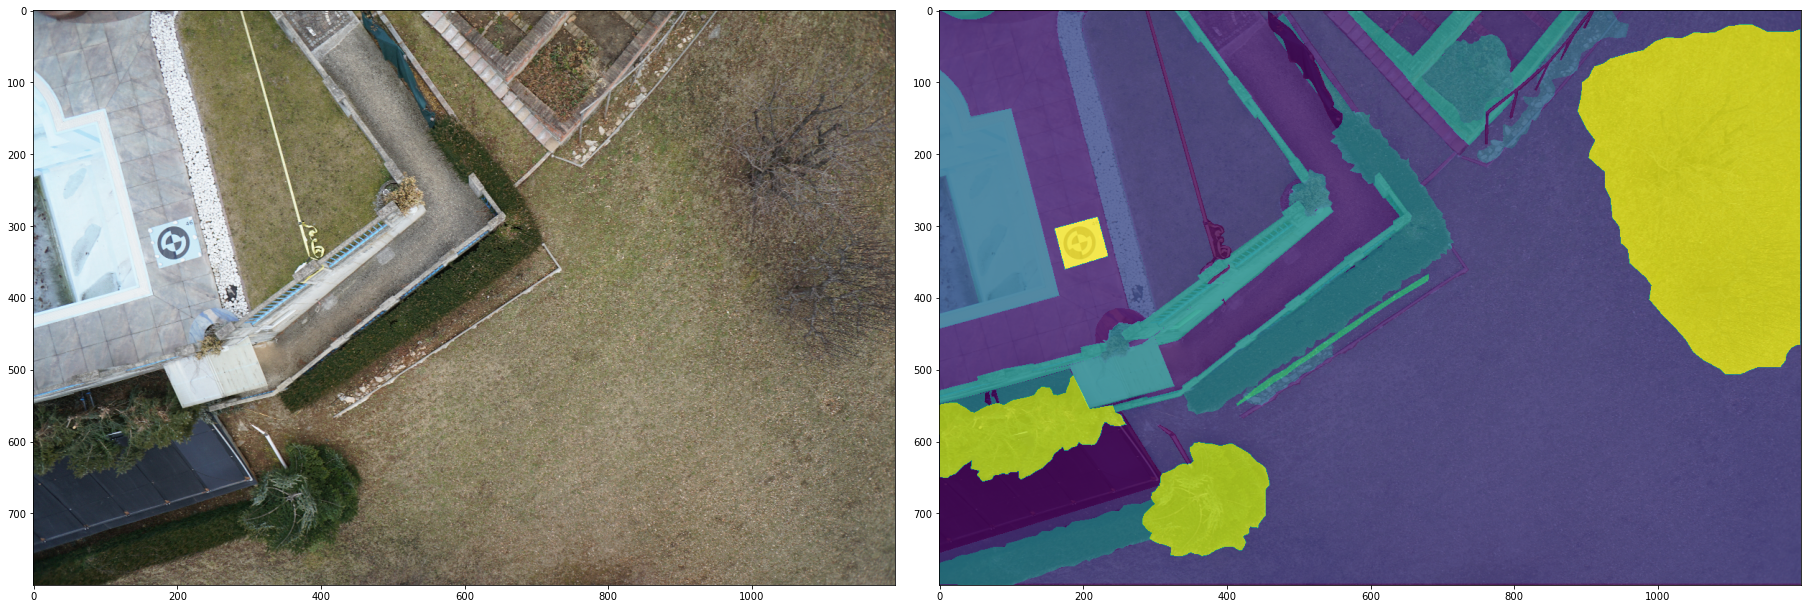

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10), constrained_layout=True)

axs[0].imshow(h[0][0])
axs[0].grid(False)

#axs[1].imshow(h[1][1])
axs[1].grid(False)
axs[1].imshow(h[0][0])
axs[1].imshow(tf.argmax(h[1][0],axis=-1),alpha = 0.8)


In [29]:
from keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate, Conv2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from tensorflow.keras.optimizers import Adam

def mobileunet(input_size, num_classes):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)    
    
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)
    
    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)
    
    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)
    
    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)    
    conv8  = BatchNormalization()(conv8)
    
    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)        
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    output = conv10
    return Model(inputs, output)

In [30]:

model = mobileunet((800, 1200, 3),Num_Classes)
model.summary()

In [31]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(Train_BatchDataset, validation_data=Eval_BatchDataset, epochs=25)

Epoch 1/25


def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size[0],image_size[1] , 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=combined[1], num_classes=combined[0])
model.summary()